# Library pageviews data

This is data from Google Analytics on a subset of library item web page views from 2012.

It has been severely reduced in size so that we can learn more about how to explore using Altair. You can see a version that deals with about a 20x larger subset in the `20_LibraryPageviews.ipynb` in this same repository.

In [2]:
import pandas as pd
import altair as alt
from altair import datum

## Read in library web site page views data

The data documents web views of items in the Duke Library catalogue. 

- Each row documents visitors to a particular item page within an hour during 2012. 
- Things like the item URL have been stripped out,
- but a Library of Congress Category (LCC) has been retained for the item. 
- The data also includes the rough location of the visitor, and 
- how may people from that location viewed the page during that hour.

In [3]:
pageviews = pd.read_csv('data/pageviews_2012_small.csv')
pageviews.head()

,timestamp,visitors,city,region,country,longitude,latitude,lcc_description
0,2012-01-01 16:00:00,1,Montreal,Quebec,Canada,-73.5542,45.5089,Military Science
1,2012-01-01 13:00:00,1,Durham,North Carolina,United States,-78.8986,35.9940,History Of The Americas
2,2012-01-01 10:00:00,1,Edinburgh,Scotland,United Kingdom,-3.1875,55.9502,Social Sciences
3,2012-01-01 18:00:00,1,Plymouth,England,United Kingdom,-4.1427,50.3704,NaN
4,2012-01-01 09:00:00,1,Edinburgh,Scotland,United Kingdom,-3.1875,55.9502,Social Sciences


In [4]:
len(pageviews)

10278

### View the Pandas column data types

In [5]:
pageviews.dtypes

timestamp           object
visitors             int64
city                object
region              object
country             object
longitude          float64
latitude           float64
lcc_description     object
dtype: object

## Change ISO_time to a true date and time data type

Note that the "timestamp" column has `dtype=object`. That is the same thing as a text string.

**To use the Altair date and time functionality, we need to convert these timestamp strings into Python `datetime` objects.**

In [6]:
pageviews['timestamp'] = pd.to_datetime(pageviews.timestamp)
pageviews.dtypes

timestamp          datetime64[ns]
visitors                    int64
city                       object
region                     object
country                    object
longitude                 float64
latitude                  float64
lcc_description            object
dtype: object

## MaxRowsError

As we saw in a previous lession, we often hit a `MaxRowsError` when we display too much data on a page. We can take off limit for number of rows displayed on a page, but that's not a great idea because the notebook will have a Vega-Lite JSON specification (text) embedded for every output pane, which also includes the data, so you end up with huge notebooks!

**Instead, we can specify that the outputs should just refer to a JSON file on your local drive and load in the data from there for each plot.**

See the Altair tutorial notebook `03-Binning-and-aggregation` for more details.

In [7]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## EXERCISE: Vertical bars of visitors per country

Make a bar chart of *sum of the number of visitors* (vertical axis) *per country* (horizontal axis) over all the data.

In [ ]:
alt.Chart(___).mark_____().encode(
    x = ___,
    y = ___
)

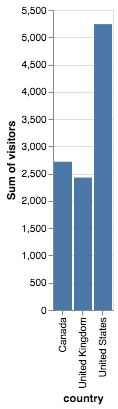

In [9]:
# Solution

alt.Chart(pageviews).mark_bar().encode(
    x = 'country',
    y = 'sum(visitors)'
)

## Sum of visitors within Library of Congress Categories by country

If we want to see how may items were viewed per LCC category, a bar chart is a good starting place. 

Since the label lines are long, it's easier to read them if they're horizontal.

We can also split these bars by country using color to give us a general sense of the split, *as long as we remember that it's not easy for people to compare bars that don't have the same baseline*.

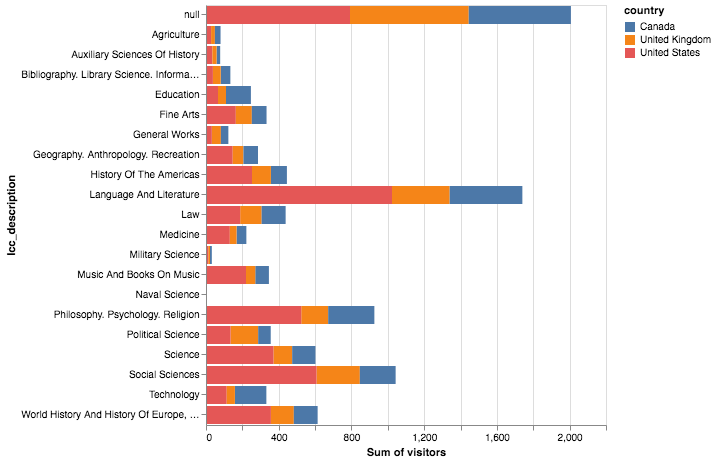

In [10]:
alt.Chart(pageviews).mark_bar().encode(
    x = 'sum(visitors)',
    y = 'lcc_description',
    color = 'country'
)

### Providing extra arguments for encoding channels

Up until now we have used simple expressions for `x=` and `y=` because all we were feeding Altair was a column or a simple aggregation expression on a column.

**Sometimes you need to give extra arguments to alter the way the axes are displayed. Altair has special objects for the encoding channels, to help you do that.**

- They all start with capital letters, and 
- you have to reference them starting with the altair module.

e.g. 

`alt.Y('lcc_description', sort='descending')`

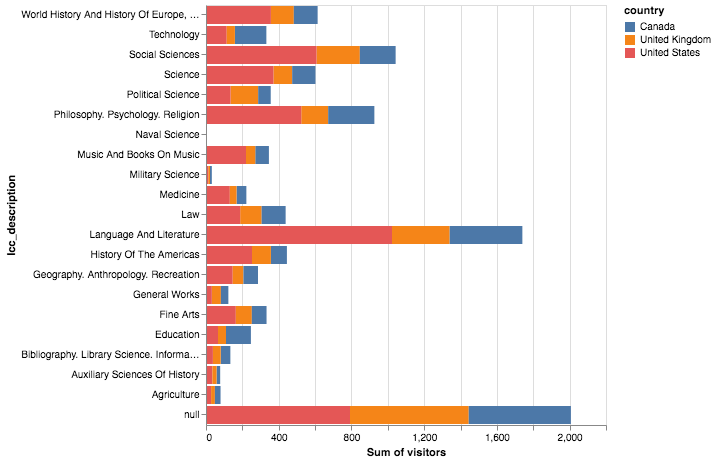

In [11]:
alt.Chart(pageviews).mark_bar().encode(
    x = 'sum(visitors)',
    y = alt.Y('lcc_description', sort='descending'),
    color = 'country'
)

## Sorting bars by sum of visitors

**Alphabetical ordering is rarely the best choice for a categorical axis!** 

It's handy for lookup in a long list, but **ordering by a quantity lets us see the patterns in the data more easily, and automatically gives us a ranking of the categories**.

The object we use for sorting an encoding field is `alt.EncodingSortField()`, which is unfortunately a long name. We give it 

- the field to sort by – *(e.g. `field='visitors'`)*
- an aggregation function for that field – *(e.g. `op='sum'` or `op='mean'`)*
- which order to sort – *(`order='ascending'` or `order='descending'`)*

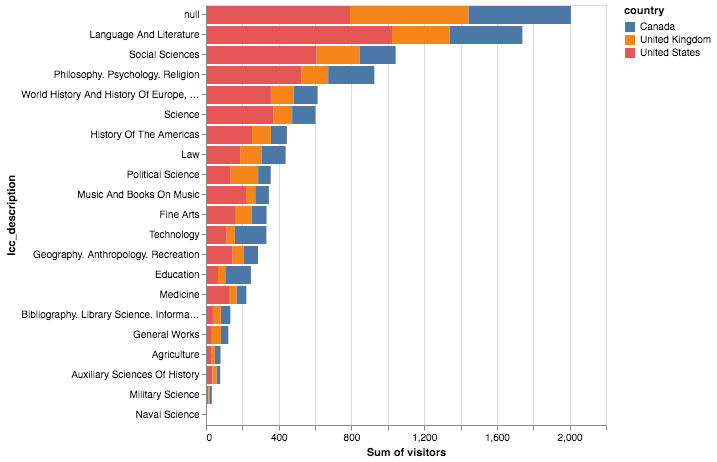

In [22]:
alt.Chart(pageviews).mark_bar().encode(
    x = 'sum(visitors)',
    y = alt.Y('lcc_description',
            sort=alt.EncodingSortField(
                field='visitors',
                op='sum',
                order='descending'
            )
    ),
    color = 'country'
)

## Log scale on number of visitors

Let's introduce a log scale on X, since the x values distribution is a bit skewed. That way it'll be easier to see the small and large values at the same time.

**With a log scale you shouldn't use bars, since there's no zero-point, so we'll switch to `mark_point()`**

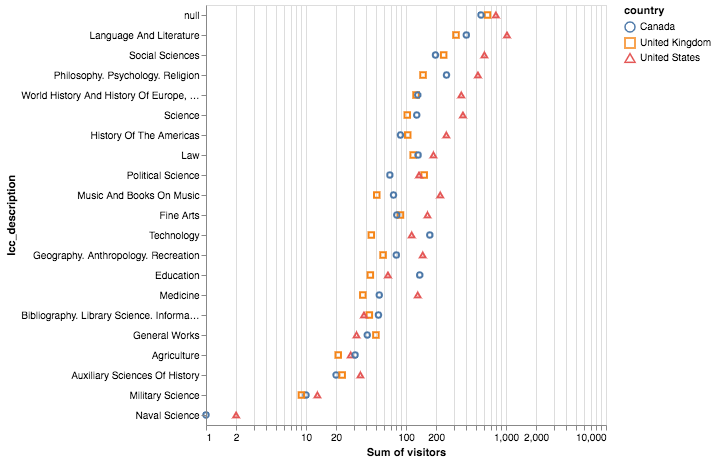

In [30]:
log_symbols_plot = alt.Chart(pageviews).mark_point().encode(
    x = alt.X('sum(visitors)', scale=alt.Scale(type='log')),
    y = alt.Y('lcc_description',
            sort=alt.EncodingSortField(
                field="visitors",
                op="sum",
                order="descending"
            )
    ),
    color = 'country',
    shape = 'country'
)

log_symbols_plot

## Configuring grid lines

Altair's default is to put grid lines on a quantitative axis, but here let's use grids on the categorical Y-axis to help us associate the labels with the points.

- We could add an `axis=alt.Axis(grid=True)` or `grid=False` to the individual encoding X and Y fields
- If we wanted to control both X and Y together, we could add a `.configure_axis(grid=True)` to the Chart
- Here we'll turn on Y axis grids with  `.configure_axisY(grid=True)`

The grid lines in Altair can only go where there are axis values, so if we wanted to control the number of grid lines for the x-axis, we would need to manually set the values.

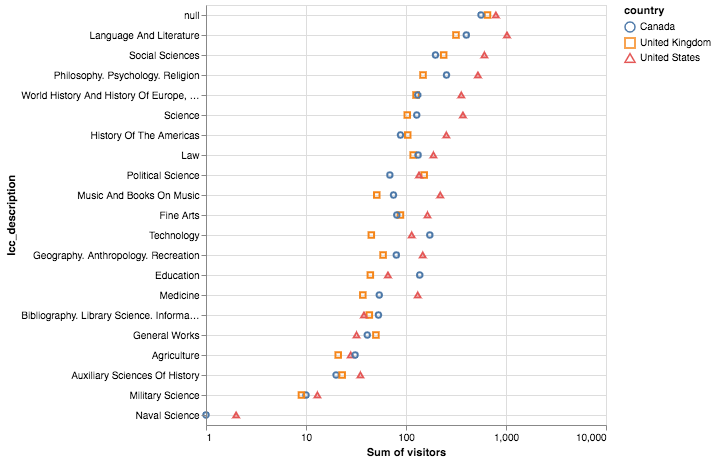

In [41]:
log_symbols_plot.encode(
    x = alt.X('sum(visitors)', 
              scale=alt.Scale(type='log'), 
              axis=alt.Axis(values=[1,10,100,1000,10000])
             )
).configure_axisY(grid=True)

### Alternative log scales

Sometimes the numbers and lookup work out better if you do **a log scale that's not base 10.**

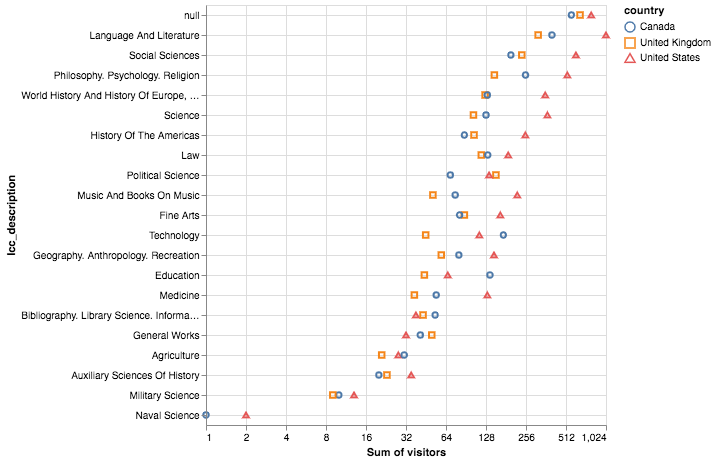

In [42]:
log_symbols_plot.encode(
    x = alt.X('sum(visitors)',
              scale=alt.Scale(type='log', base=2)
             )
).configure_axisY(grid=True)

# TimeUnit transform: 

## Visitors continuous time line

**For time series, it's often useless to view our data in the original fine event detail!** 

If we look at timestamps and visitors directly, it looks like a bunch of very closely spaced ones with a few twos and threes, etc.

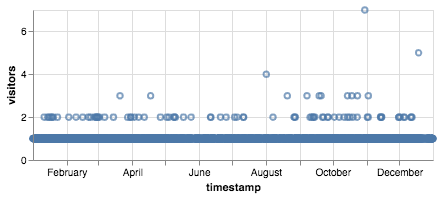

In [48]:
alt.Chart(pageviews).mark_point().encode(
    x = 'timestamp:T',
    y = 'visitors:Q'
).properties(
    width=400,
    height=150
)

## Time aggregation

We'd like to aggregate it on different time scales to see what patterns pop out. We saw some aggregation already with the `sum(visitors)` and sorting, but **Altair has many built-in time-scale aggregation functions, too, called TimeUnit Transforms.**

The documentation lists the [Timeunit valid entries](https://altair-viz.github.io/user_guide/transform.html#timeunit-transform)

### A sum of visitors per month shows some seasonal detail

Here we'll try a couple of different time scales on which to aggregate. First, monthly with `yearmonth()` to see the very coarse-scale trends over the academic year.

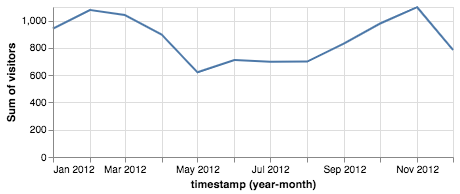

In [43]:
alt.Chart(pageviews).mark_line().encode(
    x = 'yearmonth(timestamp):T',
    y = 'sum(visitors):Q'
).properties(
    width=400,
    height=150
)

### Sum of visitors per day adds within-week detail

`yearmonthdate()` retains all of these, the year month and date, aggregating to the day level.

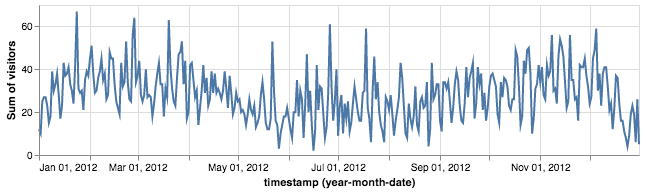

In [16]:
alt.Chart(pageviews).mark_line().encode(
    x = 'yearmonthdate(timestamp):T',
    y = 'sum(visitors):Q'
).properties(
    width=600,
    height=150
)

## Just Durham data using transform_filter()

**You can see the school holidays more clearly in the Durham pageviews** as subtle drops in the number of visitors.

*Note: **datum is just a way to reference the data elements in each row** instead of a whole column*

*Note also, that if we have lots of data, these types of filtering operations are faster in Pandas than in Altair, so you can pre-filter your data before feeding it to Altair.*

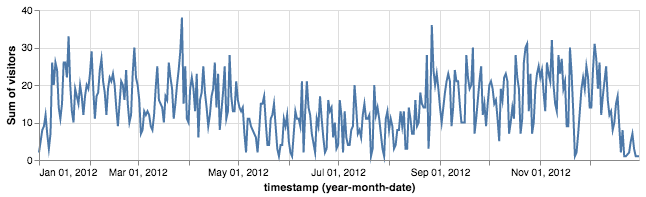

In [17]:
alt.Chart(pageviews).mark_line().encode(
    x = 'yearmonthdate(timestamp):T',
    y = 'sum(visitors):Q',
    tooltip = 'yearmonthdate(timestamp):T'
).transform_filter(
    datum.city == 'Durham'
).properties(
    width=600,
    height=150
)

### Looking at categorical days of week shows just the within-week detail

**If we want to look at something like how visitors tend to vary over the week, we'd like to ignore the specific month and year, and look at all Sundays, all Mondays, etc.**

`day()` is the right TimeUnit transform for this.

*I don't like how many grid lines are shown by default, and how the days at the ends of the week are offset from the grid lines, but we could customize that if we wanted to.*

**Try changing the Temporal X axis (:T) to Ordinal (:O) to see a cleaner picture.**

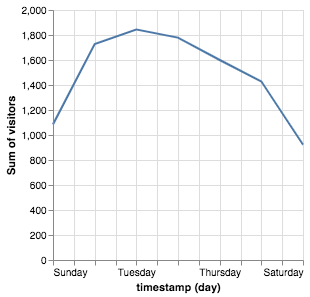

In [18]:
alt.Chart(pageviews).mark_line().encode(
    x = 'day(timestamp):T',
    y = 'sum(visitors):Q'
).properties(
    width=250,
    height=250
)

## TimeUnit transform: Visitors by hour of day

We did the days of the week earlier. Another interesting visualization is hours of the day.

If you wanted to make a bar chart out of this, you'd need to change to `mark_bar()`, as well as `T` data type to ordinal `O`.

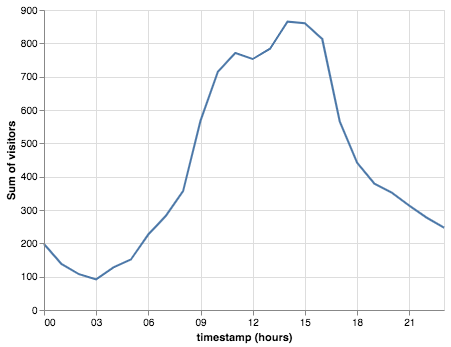

In [50]:
alt.Chart(pageviews).mark_line().encode(
    x = 'hours(timestamp):T',
    y = 'sum(visitors):Q'
)

### Canada, UK time shift

If we filter down to just Canadian and UK visitors, and color by country, we can see a shift in the peak viewing time of day corresponding to their respective time zones.

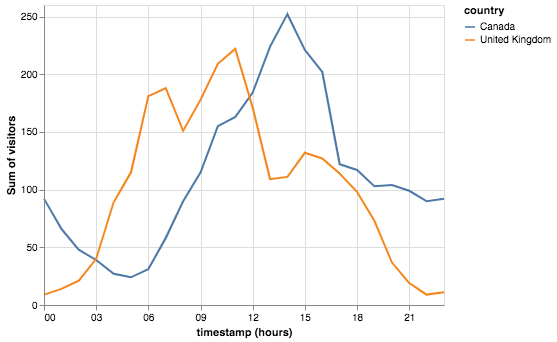

In [24]:
alt.Chart(pageviews).mark_line().encode(
    x = 'hours(timestamp):T',
    y = 'sum(visitors):Q',
    color = 'country'
).transform_filter(
    (datum.country == 'Canada') | (datum.country == 'United Kingdom')
)

## EXERCISE: Weekday vs hour of day heatmap

A heatmap is a compact way to view typical patterns throughout the day, and how that varies by weekday.

Now, put together the earlier examples to create the visualization below. Days of the week are on the vertical axis, hours of the day are on the horizontal, and color is the number of visitors. *(I've removed some of the axis labels to hide hints from you.)*

*Hint: you need to change from a Time data type to Ordinal to get discreet marks*

In [ ]:
alt.Chart(----).mark_----().encode(
    ----
    ----
    ----
)

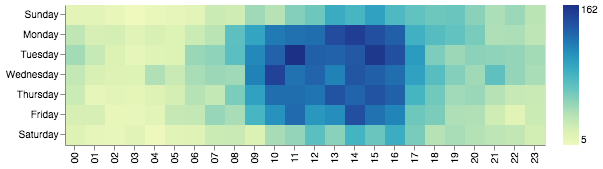

In [25]:
# Solution
# Note: I've made this more complicated than it needs to be to hide the header names

alt.Chart(pageviews).mark_rect().encode(
    x = alt.X('hours(timestamp):O', title=None),
    y = alt.Y('day(timestamp):O', title=None),
    color = alt.Color('sum(visitors)', title=None)
)